<a href="https://colab.research.google.com/github/CoolCodeMan/intro2LT/blob/Jenny/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
# importataan koodissa tarvittavat asiat
import pandas as pd

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import sklearn.svm
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

import numpy as np

from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.activations import softmax
from keras import optimizers
from keras import callbacks

import os
import pickle

%matplotlib inline
import matplotlib.pyplot as plt





# haetaan aineistot
!wget -nc -O joy-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/train.tsv
!wget -nc -O joy-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv
!wget -nc -O joy-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/test.tsv

File ‘joy-train.tsv’ already there; not retrieving.
File ‘joy-dev.tsv’ already there; not retrieving.
File ‘joy-test.tsv’ already there; not retrieving.


In [119]:
# Luetaan train-tiedosto ja tallennetaan se joy_trainiin käyttäen pandas-kirjastoa (importattu as pd).
with open("joy-train.tsv", "r") as f:
  joy_train = pd.read_csv(("joy-train.tsv"), header=0, names=['annotation','text'], sep='\t') 

# Katsotaan, miltä data näyttää.
print(joy_train[:10])
print(type(joy_train))

# Luetaan dev-tiedosto ja atallennetaan se joy_deviin.
with open("joy-dev.tsv", "r") as f:
  joy_dev = pd.read_csv(("joy-dev.tsv"), header=0, names=['annotation','text'], sep='\t') 

# Seuraavaksi luetaan tekstit ja niiden annotationit omiin listoihinsa molempien (train ja dev) osalta. 
# Tässä voisi käyttää myös list comprehensionia, mutta "auki kirjoitettu" for-loop helpompi ymmärtää!

train_texts = []
for i in joy_train["text"]:
  train_texts.append(i)
train_labels = []
for i in joy_train["annotation"]:
  train_labels.append(i)

dev_texts = []
for i in joy_dev["text"]:
  dev_texts.append(i)
dev_labels = []
for i in joy_dev["annotation"]:
  dev_labels.append(i)

# Tarkistetaan että molemmissa on tekstejä yhtä paljon kuin labeleitä

assert len(train_texts) == len(train_labels)
assert len(dev_texts) == len(dev_labels)

# Katsotaan, mitä listat pitävät sisällään.

for label, text in list(zip(train_labels, train_texts))[:20]:
  print(label,text)
for label, text in list(zip(dev_labels, dev_texts))[:20]:
  print(label,text)

# Emme sekoita aineistoa, koska meillä on valmiiksi jaetut datasetit.

  annotation                                               text
0        joy  Tuntuu mukavalta päästä taas hoitotyön pariin ...
1        joy                          Ilo oli minun puolellani.
2    not-joy  Turkkilaiset kollegani suuresta Turkin kansall...
3        joy    Haluan sanoa, että olet tehnyt loistavaa työtä.
4        joy  Hyvä kun muistutit, että Noin viikon uutiset i...
5    not-joy  Orpo ja Soini twiittaavat, että hallitusyhteis...
6        joy                        Moskova on kaunis keväällä.
7    not-joy  Musta ja Valkoinen haihtuvat keltaiseksi jauhe...
8        joy        Itsetehdyt croissantit maistuvat ihanilta .
9    not-joy  Jos sinusta tulee joskus sankari, lupaan olla ...
<class 'pandas.core.frame.DataFrame'>
joy Tuntuu mukavalta päästä taas hoitotyön pariin . :)
joy Ilo oli minun puolellani.
not-joy Turkkilaiset kollegani suuresta Turkin kansalliskokouksesta harmittelevat samoin tätä epäkohtaa , nimittäin että kukaan ei halua ilmeisesti puhua heidän kanssaan , e

In [120]:
# Lasketaan, minkä verran train datassa on kumpaakin labelia.
not_joys = train_labels.count("not-joy")
joys = len(train_labels)-not_joys
percent_joy = (joys/len(train_labels))*100
percent_not = 100-percent_joy

print(not_joys,joys)
print(percent_not, percent_joy)

543 414
56.739811912225704 43.260188087774296


In [121]:
# Määritellään vectorizeriksi sklearnin TfidVectorizer näillä parametreillä: binary=True tekee sen, että kaikki term frequencyt jotka on yli 0 on 1, eli
# ei oteta huomioon sitä, kuinka monta kertaa termi on dokumentissa, vaan sillä on väliä, onko se vai eikö se ole ->  binäärinen systeemi.
vectorizer=TfidfVectorizer(binary=True) 
                                        

# Tehdään sekä train- että dev-teksteistä omat feature matrixit käyttäen tätä vectorizeria (featureiden ollessa nyt siis käytännössä sanoja).
# Train-teksteihin käytetään fit_transformia, jonka avulla vectorizer oppii sanaston ja idf:t ja palauttaa document-term matriisin.
# Koska train-tekstien avulla on tehty jo fit eli opetus, deviin riittää pelkkä transform (joka palauttaa document-term matriisin)

feature_matrix_train=vectorizer.fit_transform(train_texts)
feature_matrix_dev=vectorizer.transform(dev_texts)

In [122]:
# Tehdään seuraavaksi NN-based BoW classifier

# Keras ei hyväksy numpy-matriiseja, joten ne pitää muuttaa tensor-matriiseiksi. luennolla opet selitti löytäneensä
# Käytämme kurssilla esiteltyä Stack Overflow'sta kopioitua koodia.

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

feature_matrix_train_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_train)
feature_matrix_dev_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_dev)

In [123]:
# Mutetaan labelit numeroiksi label_encoderin avulla. 
# Ensin train labeleihin fit_transform, joka sovittaa labelit numeoriksi ja palauttaa muutetut.
# Dev-labeleille ei tarvitse fittiä enää tehdä, vaan transform riittää.

label_encoder=LabelEncoder() 
class_numbers_train=label_encoder.fit_transform(train_labels)
class_numbers_dev=label_encoder.transform(dev_labels)

print("class_numbers shape=",class_numbers_train.shape)
print("class labels",label_encoder.classes_) 

class_numbers shape= (957,)
class labels ['joy' 'not-joy']


In [124]:
# Neuroverkko
# Earlystopping pysäyttää ohjelman, kun val_accuracy ei enää nouse.

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", \
                                        mode ="min", patience = 5, \
                                        restore_best_weights = True)

example_count,feature_count=feature_matrix_train.shape
example_count2=class_numbers_train.shape[0]
assert example_count==example_count2  # sanity check

# Luokkien määrä
class_count=len(label_encoder.classes_) 

# Rakennetaan neuroverkko:

inp=Input(shape=(feature_count,)) # Input-layer
hidden=Dense(1500, bias_regularizer=l2(0.00001), activation="tanh")(inp) # 1. hidden layer
hidden2=Dropout(0.8)(hidden) # 1. dropout-layer (tällä pyritään ehkäisemään over fit -ongelmaa)
hidden3=Dense(1500, bias_regularizer=l2(0.00001), activation="relu")(hidden2) # 2. hidden layer
hidden4=Dropout(0.5)(hidden3) # 2. dropout-layer
outp=Dense(class_count,activation='sigmoid')(hidden4) # Output-layer

model=Model(inputs=[inp], outputs=[outp])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics="accuracy")

hist=model.fit(feature_matrix_train_tf,class_numbers_train,\
               validation_data=(feature_matrix_dev_tf,class_numbers_dev), callbacks = [earlystopping], \
               batch_size=8,verbose=1,epochs=1000)



Epoch 1/1000
120/120 [==============================] - 6s 44ms/step - loss: 0.6906 - accuracy: 0.5479 - val_loss: 0.6753 - val_accuracy: 0.5694
Epoch 2/1000
120/120 [==============================] - 5s 43ms/step - loss: 0.6729 - accuracy: 0.5803 - val_loss: 0.6540 - val_accuracy: 0.5833
Epoch 3/1000
120/120 [==============================] - 5s 43ms/step - loss: 0.6405 - accuracy: 0.6098 - val_loss: 0.6192 - val_accuracy: 0.6736
Epoch 4/1000
120/120 [==============================] - 5s 43ms/step - loss: 0.5922 - accuracy: 0.7046 - val_loss: 0.5708 - val_accuracy: 0.7153
Epoch 5/1000
120/120 [==============================] - 5s 43ms/step - loss: 0.4897 - accuracy: 0.8396 - val_loss: 0.5314 - val_accuracy: 0.7153
Epoch 6/1000
120/120 [==============================] - 5s 43ms/step - loss: 0.3406 - accuracy: 0.9158 - val_loss: 0.5419 - val_accuracy: 0.7361
Epoch 7/1000
120/120 [==============================] - 5s 44ms/step - loss: 0.2077 - accuracy: 0.9565 - val_loss: 0.5750 - val_ac

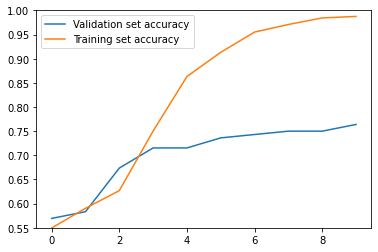

In [125]:
# Kaavio training- ja validation-accuracysta.

plt.ylim(0.55,1.0)
plt.plot(hist.history["val_accuracy"],label="Validation set accuracy")
plt.plot(hist.history["accuracy"],label="Training set accuracy")
plt.legend()
plt.show()

In [126]:
# Testaus

with open("joy-test.tsv", "r") as f:
  joy_test = pd.read_csv(("joy-test.tsv"), header=0, names=['annotation','text'], sep='\t')

test_texts = []
for i in joy_test["text"]:
  test_texts.append(i)
test_labels = []
for i in joy_test["annotation"]:
  test_labels.append(i)

not_joys = test_labels.count("not-joy")
joys = len(test_labels)-not_joys
percent_joy = (joys/len(test_labels))*100
percent_not = 100-percent_joy

print(f"Not-joy: {not_joys}, {percent_not:.2f}% \nJoy: {joys}, {percent_joy:.2f}%\n")

assert len(test_texts) == len(test_labels)
feature_matrix_test=vectorizer.transform(test_texts)
feature_matrix_test_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_test)
class_numbers_test=label_encoder.transform(test_labels)
model.evaluate(feature_matrix_test_tf,class_numbers_test)

Not-joy: 157, 56.68% 
Joy: 120, 43.32%

9/9 [==============================] - 0s 7ms/step - loss: 0.4839 - accuracy: 0.7834


[0.48385852575302124, 0.7833935022354126]